In [1076]:
%pip install category_encoders

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1077]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
import regex as re

In [1078]:
data = pd.read_csv("../housing_data/opa_properties_public.csv", low_memory=False)

In [1079]:
data_copy = data

In [1080]:
data = data_copy

In [1081]:
data.shape

(582933, 82)

In [1082]:
data.columns

Index(['the_geom', 'the_geom_webmercator', 'assessment_date', 'basements',
       'beginning_point', 'book_and_page', 'building_code',
       'building_code_description', 'category_code',
       'category_code_description', 'census_tract', 'central_air',
       'cross_reference', 'date_exterior_condition', 'depth',
       'exempt_building', 'exempt_land', 'exterior_condition', 'fireplaces',
       'frontage', 'fuel', 'garage_spaces', 'garage_type',
       'general_construction', 'geographic_ward', 'homestead_exemption',
       'house_extension', 'house_number', 'interior_condition', 'location',
       'mailing_address_1', 'mailing_address_2', 'mailing_care_of',
       'mailing_city_state', 'mailing_street', 'mailing_zip', 'market_value',
       'market_value_date', 'number_of_bathrooms', 'number_of_bedrooms',
       'number_of_rooms', 'number_stories', 'off_street_open',
       'other_building', 'owner_1', 'owner_2', 'parcel_number', 'parcel_shape',
       'quality_grade', 'recording_d

In [1083]:
# The following columns were deemed to not impact the model based on the data they provide. Many of the columns were missing data and most of the categorical columns have no correlations
drop_column_list = ['the_geom', 'assessment_date','beginning_point', 'book_and_page', 'category_code_description', 'cross_reference', 'house_number','location', 'mailing_address_1', 'mailing_address_2', 
                    'mailing_care_of', 'mailing_city_state', 'mailing_street', 'market_value_date','the_geom_webmercator','other_building','owner_1', 'owner_2', 'parcel_number', 'recording_date', 
                    'sale_date', 'registry_number', 'sale_price', 'unit', 'objectid','building_code', 'census_tract', 'date_exterior_condition', 'year_built_estimate', 'house_extension', 'mailing_zip', 
                    'sewer', 'site_type','state_code', 'street_designation', 'street_name', 'street_direction', 'geographic_ward', 'quality_grade', 'building_code_description', 'pin', 'garage_type',
                    'street_code', 'building_code_description_new', 'building_code_new', 'unfinished', 'fuel'  ]

data = data.drop(drop_column_list, axis = 1)

In [1084]:
# Drop empty rows
data = data.dropna(subset=["market_value"])

In [1085]:
# Check if there are still null rows
data.market_value.isnull().any()

False

In [1086]:
data.shape

(582913, 35)

In [1087]:
len(data.columns)

35

In [1088]:
data.columns

Index(['basements', 'category_code', 'central_air', 'depth', 'exempt_building',
       'exempt_land', 'exterior_condition', 'fireplaces', 'frontage',
       'garage_spaces', 'general_construction', 'homestead_exemption',
       'interior_condition', 'market_value', 'number_of_bathrooms',
       'number_of_bedrooms', 'number_of_rooms', 'number_stories',
       'off_street_open', 'parcel_shape', 'separate_utilities', 'suffix',
       'taxable_building', 'taxable_land', 'topography', 'total_area',
       'total_livable_area', 'type_heater', 'utility', 'view_type',
       'year_built', 'zip_code', 'zoning', 'lat', 'lng'],
      dtype='object')

In [1089]:
# Drop rows that have a market value of 0
data = data.drop(data[data.market_value == 0].index)

In [1090]:
corr = data.corr()
corr.sort_values(["market_value"],ascending = False, inplace = True)
print(corr.market_value)

C:\Users\gympr\AppData\Local\Temp\ipykernel_576\420568462.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


market_value           1.000000
exempt_building        0.723251
taxable_land           0.669632
taxable_building       0.663446
total_livable_area     0.517544
exempt_land            0.407638
fireplaces             0.313073
number_of_rooms        0.282594
number_of_bathrooms    0.211712
frontage               0.170192
number_stories         0.154825
depth                  0.148069
garage_spaces          0.126214
category_code          0.114663
total_area             0.091730
homestead_exemption    0.070511
zip_code               0.017103
off_street_open       -0.004000
lng                   -0.007567
number_of_bedrooms    -0.023070
lat                   -0.026878
year_built            -0.030077
exterior_condition    -0.354686
interior_condition    -0.385431
utility                     NaN
Name: market_value, dtype: float64


Text(0.5, 0, 'Number of Missing values')

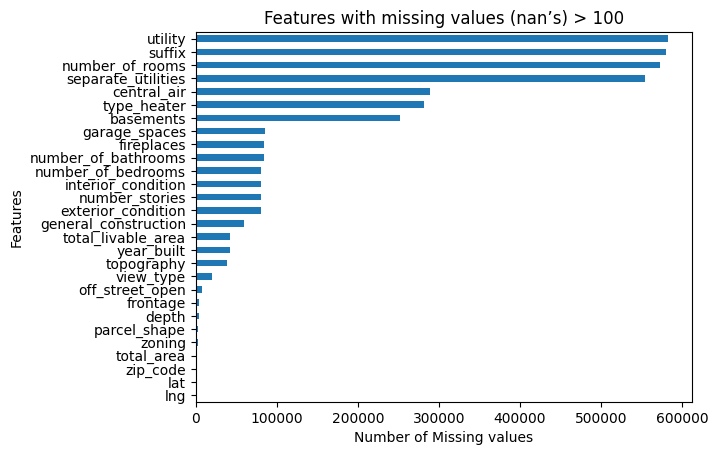

In [1091]:
# Visualize missing values in columns
missing = data.isnull().sum()
missing = missing[missing >= 100]
missing.sort_values(inplace=True)
missing.plot.barh()
plt.title("Features with missing values (nan’s) > 100")
plt.ylabel("Features")
plt.xlabel("Number of Missing values")

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Fill in null data

#### Numerical Data Non Categorical
- Depth
- Longitude
- Latitude
- Fireplaces
- Number of Stories
- Number of bathrooms
- Number of bedrooms
- Number of rooms
- Total area
- Total livable area
- Off street open
- Exempt Building
- Exempt Land
- Garage Spaces
- Homestead Exemption
- Market Value (Target)
- Taxable Building
- Taxable Land

#### Categorical Char
- Basements
- Central Air
- Garage Type
- General Construction
- Parcel Shape
- Separate Utilities
- Suffix
- Topography
- Heater
- Utility
- View Type
- Zoning
#### Categorical Numerical
- Category Code
- Zipcode
- Exterior Condition
- Year Built
- Interior Condition

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


### Category Code

- Code value: 1 = Single Family
- Code value: 2 = Multi Family
- Code value: 3 = Mixed Use
- Code value: 4 = Commercial
- Code value: 5 = Industrial
- Code value: 6 = Vacant Land

In [1092]:
data.category_code.value_counts(dropna=False)

1     463162
6      42106
2      40743
3      14300
4      12836
5       4165
14      2813
10       840
13       834
8        507
9        129
12       119
7         97
15        27
11        19
16        13
Name: category_code, dtype: int64

In [1093]:
# Create a mask to drop rows
values_to_drop = [num for num in range(4, 17)]
mask_category_code = data["category_code"].isin(values_to_drop)
data = data.loc[~mask_category_code]

In [1094]:
# Code value: 1 = Single Family
# Code value: 2 = Multi Family
# Code value: 3 = Mixed Use
data.category_code.value_counts(dropna=False)

1    463162
2     40743
3     14300
Name: category_code, dtype: int64

In [1095]:
data.shape

(518205, 35)

### Depth

In [1096]:
data.depth.value_counts(dropna=False)

100.0    33325
0.0      31453
90.0     20033
70.0     15828
60.0     15223
         ...  
504.0        1
336.0        1
557.0        1
596.0        1
488.0        1
Name: depth, Length: 638, dtype: int64

In [1097]:
# Delete rows that have a depth of 0
data = data.drop(data[data.depth == 0].index)
data = data.dropna(subset=["depth"])

In [1098]:
data.shape

(483630, 35)

### Longitude

In [1099]:
# Replace empty longitude values with the mean
data["lng"] = data.lng.fillna(data.lng.mean())

In [1100]:
# Convert the longitude values to be positive for machine learning purposes
data.loc[:, "lng"] = data['lng'].abs()

### Latitude


In [1101]:
# Replace empty latitude values with the mean
data["lat"] = data.lat.fillna(data.lat.mean())

In [1102]:
# Convert the latitude values to be positive for machine learning purposes
data.loc[:, "lat"] = data['lat'].abs()

In [1103]:
data.shape

(483630, 35)

### Basements

- [NOTE: REPLACING 'NaN' WITH 'K'] 
- 0 = No Basement [NOTE: REPLACING '0' WITH 'L']
- D = Full – Unknown Finish
- F = Partial - Semi-Finished 
- H = Partial - Unknown Finish
- C = Full - Unfinished
- A = Full - Finished 
- J = Unknown Size - Unfinished
- E = Partial - Finished 
- I = Unknown Size - Finished 
- G = Partial - Unfinished
- B = Full - Semi-Finished

- 1 = ? Replace with M
- 2 = ? Replace with N
- 3 = ? Replace with O
- 4 = ? Replace with P

In [1104]:
data.basements.value_counts(dropna=False)


NaN    157326
D      107751
F       64119
H       57380
C       33954
A       27565
E        9951
0        7922
J        7551
G        4352
B        3113
I        2042
1         488
4          91
2          20
3           5
Name: basements, dtype: int64

In [1105]:
data.loc[:, "basements"] = data.loc[:, "basements"].fillna('K')
replacement_dict = {'0': 'L', '1': 'M', '2': 'N', '3': 'O', '4': 'P'}
data['basements'] = data['basements'].replace(replacement_dict, regex=True)

### Central Air

In [1106]:
data.central_air.value_counts(dropna=False)

NaN    214517
N      163214
Y      104682
0        1078
1         139
Name: central_air, dtype: int64

In [1107]:
# Replacing '0' with 'N' (i.e. NO Central Air)
data.loc[:, "central_air"] = data['central_air'].replace('0', 'N')
# Replacing the "NaNs" with 'N'
data.loc[:, "central_air"] = data['central_air'].fillna('N')
# Replacing '1' with 'Y' (i.e. Central Air)
data.loc[:, "central_air"] = data['central_air'].replace('1', 'N')

### Exterior Condition

- 4.0 Average
- 3.0 Above Average
- 5.0 Below Average
- 2.0 Newer Construction / Rehabbed
- 7.0 Sealed / Structurally Compromised
- 6.0 Vacant
- 0.0 Not Applicable

In [1108]:
data.exterior_condition.value_counts(dropna=False)

4.0    371682
3.0     40275
5.0     24236
NaN     17139
1.0     12216
2.0     11914
7.0      3454
6.0      2658
0.0        56
Name: exterior_condition, dtype: int64

In [1109]:
# Fill in nan with not applicable (0.0)
data.loc[:, "exterior_condition"] = data.loc[:, "exterior_condition"].fillna(0.0)

### General Construction

- A = Common brick 
- B = Brick and Siding 
- E = Stone 
- C = Frame and siding 
- F = Stucco/Cement 
- G = Other/Mix 
- H = Brick and stucco 
- J = Stone/stucco 
- I = Stucco and siding 
- D = Frame and shingle 

In [1110]:
data.general_construction.value_counts(dropna=False)

A      406305
B       32083
C       10964
E       10930
F        7258
NaN      4960
H        4712
G        1877
J        1712
I        1141
3        1014
1         284
D         251
5          99
6          27
9          11
8           1
4           1
Name: general_construction, dtype: int64

In [1111]:
data["general_construction"].unique()

array(['A ', 'E ', nan, 'B ', 'G ', '1 ', 'F ', 'C ', 'I ', 'H ', 'J ',
       'D ', '3 ', '5 ', '6 ', '9 ', '8 ', '4 '], dtype=object)

In [1112]:
# Replace Nan with other (G)
data.loc[:, "general_construction"] = data.loc[:, "general_construction"].fillna("G")
# Replace number with numerical counter part (not sure if this is correct)
replacement_dict = {'1 ': 'A ', '3 ': 'C ', '4 ': 'D ', '5 ': 'E ', '6 ': 'F ', '8 ': 'H ', '9 ': 'I '}
data.loc[:, "general_construction"] = data["general_construction"].replace(replacement_dict)

### Parcel Shape

- E = Rectangular
- A = Other than a square, rectangular or triangle 
- B = Curves, narrow portions, long access driveways 
- C = Triangular 
- F = NaN 
- D = Long and narrow

In [1113]:
data.parcel_shape.value_counts(dropna=False)

E      446554
A       31971
B        4202
C         837
D          48
NaN        18
Name: parcel_shape, dtype: int64

In [1114]:
# Replacing the "NaN's" with 'F'
data.loc[:, "parcel_shape"] = data['parcel_shape'].fillna('F')

### Seperate Utilities

- D = Non 2 to 4 apartments
- B = Part Separate
- A = Central (heater, hot water tank, electrical, gas)
- C = All seperate (except water)

In [1115]:
data.separate_utilities.value_counts(dropna=False)

NaN    460218
B       10478
A        8826
C        4108
Name: separate_utilities, dtype: int64

In [1116]:
data.loc[:, "separate_utilities"] = data['separate_utilities'].fillna('D')

### Suffix

- NaN [Replacing NaN’s with N — No suffix needed/provided]
- 2      [Replacing 2 with H (half an address)]
- R      to indicate Rear in address
- A      to indicate Air Rights
- L      Leasehold
- E      

In [1117]:
data.suffix.value_counts(dropna=False)

NaN    482825
2         383
R         372
A          48
L           2
Name: suffix, dtype: int64

In [1118]:
data["suffix"].unique()

array([nan, '2', 'R', 'L', 'A'], dtype=object)

In [1119]:
data.loc[:, "suffix"] = data["suffix"].fillna('N')
data.loc[:, "suffix"] = data["suffix"].replace('2','H')

### Topography

- F = Street level 
- A = Above Street Level 
- E = Other and NaN’s 
- B = Below Street Level 
- C = Flood Plain 
- D = Rocky 

In [1120]:
data.topography.value_counts(dropna=False)

F      444991
A       28305
NaN      5338
E        4509
B         231
C         152
D         104
Name: topography, dtype: int64

In [1121]:
data.loc[:, "topography"] = data["topography"].fillna('E')

### Heater

- H = Undetermined and NaNs 
- A = Hot air (ducts) 
- B = Hot water (radiators or baseboards) 
- G = Radiant 
- N = None 
- C = Electric baseboard 
- E = Other 
- D = Outside heat pump 

In [1122]:
data.type_heater.value_counts(dropna=False)

NaN    196183
H      113768
A      103654
B       59669
G        6475
0        1651
C        1278
E         550
D         402
Name: type_heater, dtype: int64

In [1123]:
data.loc[:, "type_heater"] = data["type_heater"].fillna('H')

### Utility

A = None and NaNs 

B = Modernized 

D = Modernized and remodeled 

C = Remodeled (relates to design and floor plan) 

In [1124]:
data.utility.value_counts(dropna=False)

NaN    483630
Name: utility, dtype: int64

### View Type

In [1125]:
data.view_type.value_counts(dropna=False)

I      454497
A       10307
C        5037
D        3462
0        3305
H        2665
NaN      2261
E        1933
B         163
Name: view_type, dtype: int64

In [1126]:
data.loc[:, "view_type"] = data["view_type"].fillna('N')

### Fireplaces

In [1127]:
data.fireplaces.value_counts(dropna=False)

0.0     448846
NaN      20424
1.0      11608
2.0       1646
3.0        654
5.0        282
4.0        169
10.0         1
Name: fireplaces, dtype: int64

In [1128]:
data.loc[:, "fireplaces"] = data["fireplaces"].fillna(0.0)

### Number Stories

In [1129]:
data.number_stories.value_counts(dropna=False)

2.0    342450
1.0     61658
3.0     61289
NaN     17145
4.0      1070
5.0        10
6.0         6
0.0         2
Name: number_stories, dtype: int64

In [1130]:
data["number_stories"].unique()

array([nan,  1.,  2.,  3.,  4.,  0.,  5.,  6.])

In [1131]:
data.loc[:, "number_stories"] = data["number_stories"].fillna(0.0)

### Number of rooms

- Missing to much data. Doesnt make sense to take the mean of the rooms.

In [1132]:
data.number_of_rooms.value_counts(dropna=False)

NaN     473808
6.0       5191
7.0       1465
5.0        857
8.0        696
10.0       497
12.0       377
9.0        275
11.0        82
4.0         78
18.0        51
14.0        48
15.0        47
13.0        41
3.0         33
16.0        22
20.0        19
17.0         9
21.0         5
30.0         4
28.0         4
24.0         3
22.0         3
19.0         3
25.0         3
2.0          3
27.0         3
23.0         2
1.0          1
Name: number_of_rooms, dtype: int64

### Number of bedrooms

In [1133]:
data.number_of_bedrooms.value_counts(dropna=False)

3.0     284799
0.0      93052
4.0      49941
2.0      27035
NaN      17333
5.0       5923
6.0       3341
7.0        727
8.0        568
1.0        388
9.0        247
10.0        82
12.0        75
11.0        50
13.0        19
14.0        18
31.0        10
30.0         5
16.0         4
15.0         4
44.0         3
18.0         2
20.0         2
40.0         1
45.0         1
Name: number_of_bedrooms, dtype: int64

In [1134]:
data["number_of_bedrooms"].mean()

2.5172411574597304

In [1135]:
# Replace with the mean
data.loc[:, "number_of_bedrooms"] = data["number_of_bedrooms"].fillna(3.0)

### Number of bathrooms

In [1136]:
data.number_of_bathrooms.value_counts(dropna=False)

1.0     310087
0.0      93995
2.0      45165
NaN      19934
3.0      11016
4.0       2392
5.0        455
6.0        305
7.0         97
8.0         92
10.0        27
9.0         26
12.0        15
11.0        10
13.0         4
21.0         2
15.0         2
14.0         2
22.0         1
17.0         1
16.0         1
25.0         1
Name: number_of_bathrooms, dtype: int64

In [1137]:
data.loc[:, "number_of_bathrooms"].mean()

0.9695554846278597

In [1138]:
data.loc[:, "number_of_bathrooms"] = data["number_of_bathrooms"].fillna(1.0)

### Taxable Land

In [1139]:
data.taxable_land.value_counts(dropna=False).get(0,0)

28420

In [1140]:
data = data.dropna(subset=["taxable_land"])

### Taxable Building

In [1141]:
data = data.dropna(subset=["taxable_building"])

### Total Area

In [1142]:
data.total_area.value_counts(dropna=False).get(0,0)

0

In [1143]:
data = data[data["total_area"] != 0]

In [1144]:
data = data.dropna(subset=["total_area"])

### Total livable area

In [1145]:
data.total_livable_area.value_counts(dropna=False).get(0,0)

91

In [1146]:
area_mean = data.total_livable_area.mean()

In [1147]:
data.loc[:, "total_livable_area"] = data["total_livable_area"].fillna(area_mean)

In [1148]:
data = data[data["total_livable_area"] != 0]

### Frontage


In [1149]:
area_mean = round(data.frontage.mean())

In [1150]:
area_mean

23

In [1151]:
data.loc[:, "frontage"] = data["frontage"].fillna(area_mean)

### Exempt building

In [1152]:
data = data.dropna(subset=["exempt_building"])

### Exempt Land

In [1153]:
data = data.dropna(subset=["exempt_land"])

### Off Street Open

In [1154]:
data = data.dropna(subset=["off_street_open"])

### Zoning

In [1155]:
data = data.dropna(subset=["zoning"])

### ZipCode

In [1156]:
data = data.dropna(subset=["zip_code"])

### Year Built

In [1157]:
data = data.dropna(subset=["year_built"])

### Garage Spaces

In [1158]:
data = data.dropna(subset=["garage_spaces"])

### Interior Condition

In [1159]:
data = data.dropna(subset=["interior_condition"])

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Remove Outliers

#### Numerical Data
- Depth
- Fireplaces
- Number of Stories
- Number of bathrooms
- Number of bedrooms
- Number of rooms


### Depth

In [1160]:
# Calculate Q1, Q3, and IQR
q1 = np.percentile(data["depth"], 25)
q3 = np.percentile(data["depth"], 75)
iqr = q3 - q1

# Define lower and upper bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr


In [1161]:
data = data[(data['depth'] > lower_bound) & (data['depth'] < upper_bound)]

### Fireplace

In [1162]:
data = data[(data["fireplaces"] >= 0.0) & (data["fireplaces"] <= 5.0) ]

In [1163]:
data.shape

(449050, 35)

### Number of Stories

In [1164]:
data = data[(data["number_stories"] >= 0.0) & (data["number_stories"] <= 4.0) ]

In [1165]:
data.shape

(449038, 35)

### Number of Bathrooms

In [1166]:
data = data[(data["number_of_bathrooms"] >= 0.0) & (data["number_of_bathrooms"] <= 6.0)]

In [1167]:
data.shape

(448815, 35)

### Number of Bedrooms

In [1168]:
data = data[(data["number_of_bedrooms"] >= 0.0) & (data["number_of_bedrooms"] <= 10.0)]

In [1169]:
data.shape

(448715, 35)

# Feature Selection Categorical Data
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Categorical Char
- Basements
- Central Air
- Garage Type
- General Construction
- Parcel Shape
- Separate Utilities
- Suffix
- Topography
- Heater
- Utility
- View Type
- Zoning
#### Categorical Numerical
- Category Code
- Zipcode
- Exterior Condition
- Year Built
- Interior Condition

In [1175]:
categories = ["basements", "central_air", "general_construction", "parcel_shape", "separate_utilities", "suffix", "topography", "type_heater", "utility", "view_type", "zoning", "exterior_condition", "interior_condition", "category_code", "zip_code", "year_built"]

In [1183]:
len(categories)

16

In [1176]:
label_encoder = LabelEncoder()

In [1177]:
data[categories] = data[categories].apply(lambda col: label_encoder.fit_transform(col))


In [1178]:
categorical_data = data[categories]

In [1179]:
target_data = data["market_value"]

In [1187]:
# Apply chi-squared feature selection
k_best = SelectKBest(chi2, k=5)
X_chi2_selected = k_best.fit_transform(categorical_data, target_data)
selected_features = categorical_data.columns[k_best.get_support()]

In [1181]:
# Display the original and selected features
print("Original DataFrame:")
print(categorical_data)

print("\nSelected features after chi-squared feature selection:")
print(X_chi2_selected)

Original DataFrame:
        basements  central_air  general_construction  parcel_shape  \
27              3            0                     0             0   
66             10            0                     0             4   
72              3            0                     0             0   
75             10            0                     0             4   
132            10            0                     0             4   
...           ...          ...                   ...           ...   
582906          5            0                     0             4   
582910          7            0                     0             4   
582922         10            0                     0             4   
582923          3            0                     0             4   
582925         10            0                     0             4   

        separate_utilities  suffix  topography  type_heater  utility  \
27                       3       2           5            7        

In [1193]:
print("\nSelected feature names:")
print(selected_features)


Selected feature names:
Index(['basements', 'general_construction', 'type_heater', 'zip_code',
       'year_built'],
      dtype='object')


In [1196]:
# Drop columns
categories = ["basements", "central_air", "general_construction", "parcel_shape", 
              "separate_utilities", "suffix", "topography", "type_heater", "utility",
                "view_type", "zoning", "exterior_condition", "interior_condition", 
                "category_code", "zip_code", "year_built"]

drop_categories = [cat for cat in categories if cat not in selected_features]

In [1197]:
data = data.drop(drop_categories, axis = 1)

# Feature Selection Numerical Data

#### Numerical Data Non Categorical
- Depth
- Longitude
- Latitude
- Fireplaces
- Number of Stories
- Number of bathrooms
- Number of bedrooms
- Number of rooms
- Total area
- Total livable area
- Off street open
- Exempt Building
- Exempt Land
- Garage Spaces
- Homestead Exemption
- Market Value (Target)
- Taxable Building
- Taxable Land


In [1198]:
corr = data.corr()
corr.sort_values(["market_value"],ascending = False, inplace = True)
print(corr.market_value)

market_value            1.000000
taxable_land            0.979568
taxable_building        0.815605
total_livable_area      0.598914
exempt_building         0.436827
number_of_rooms         0.390440
number_stories          0.311470
fireplaces              0.302930
general_construction    0.174378
number_of_bathrooms     0.172300
total_area              0.151038
garage_spaces           0.140064
frontage                0.138953
depth                   0.117252
homestead_exemption     0.063869
off_street_open         0.006984
lng                    -0.051796
lat                    -0.054748
exempt_land            -0.067769
number_of_bedrooms     -0.068293
basements              -0.170572
year_built             -0.221595
type_heater            -0.240645
zip_code               -0.300076
Name: market_value, dtype: float64


# One Hot Encoding for Categories

In [ ]:
# Perform one-hot encoding on the 'Category' column
df_encoded = pd.get_dummies(data, columns=['basements'], prefix='basement')

In [ ]:
# Perform one-hot encoding on the 'Category' column
df_encoded = pd.get_dummies(df_encoded, columns=['central_air'], prefix='air')

In [ ]:
# # Perform one-hot encoding on the 'Category' column
# df_encoded = pd.get_dummies(df_encoded, columns=['fuel'], prefix='fuel')

In [ ]:
# # Perform one-hot encoding on the 'Category' column
# df_encoded = pd.get_dummies(df_encoded, columns=['garage_type'], prefix='garage')

In [ ]:
# Perform one-hot encoding on the 'Category' column
df_encoded = pd.get_dummies(df_encoded, columns=['general_construction'], prefix='construction')

In [ ]:
# # Perform one-hot encoding on the 'Category' column
# df_encoded = pd.get_dummies(df_encoded, columns=['parcel_shape'], prefix='parcel')

In [ ]:
# # Perform one-hot encoding on the 'Category' column
# df_encoded = pd.get_dummies(df_encoded, columns=['separate_utilities'], prefix='separate_utilites')

In [ ]:
# # Perform one-hot encoding on the 'Category' column
# df_encoded = pd.get_dummies(df_encoded, columns=['suffix'], prefix='suffix')

In [ ]:
# # Perform one-hot encoding on the 'Category' column
# df_encoded = pd.get_dummies(df_encoded, columns=['topography'], prefix='topography')

In [ ]:
# Perform one-hot encoding on the 'Category' column
df_encoded = pd.get_dummies(df_encoded, columns=['type_heater'], prefix='heater')

In [ ]:
# # Perform one-hot encoding on the 'Category' column
# df_encoded = pd.get_dummies(df_encoded, columns=['utility'], prefix='utility')

In [ ]:
# Perform one-hot encoding on the 'Category' column
# df_encoded = pd.get_dummies(df_encoded, columns=['view_type'], prefix='view')

# Frequency Encoding

In [1190]:
zip_code_counts = data['zip_code'].value_counts()

# Map the frequencies to the original 'ZipCode' column
data['zip_code'] = data['zip_code'].map(zip_code_counts)

In [1191]:
year_counts = data['year_built'].value_counts()

# Map the frequencies to the original 'ZipCode' column
data['year_built'] = data['year_built'].map(year_counts)